<a href="https://colab.research.google.com/github/10844110/Colab/blob/main/Assignment_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
print("PyTorch version:", torch.__version__)
print("CUDA available:", torch.cuda.is_available())

PyTorch version: 2.8.0+cu126
CUDA available: True


In [2]:
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

BATCH_SIZE = 64

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.1307,), (0.3081,))
])

train_ds = datasets.MNIST("./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST("./data", train=False, download=True, transform=transform)

train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=True,  num_workers=2, pin_memory=True)
test_loader  = DataLoader(test_ds,  batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

len(train_ds), len(test_ds)

100%|██████████| 9.91M/9.91M [00:00<00:00, 20.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 492kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.58MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 8.93MB/s]


(60000, 10000)

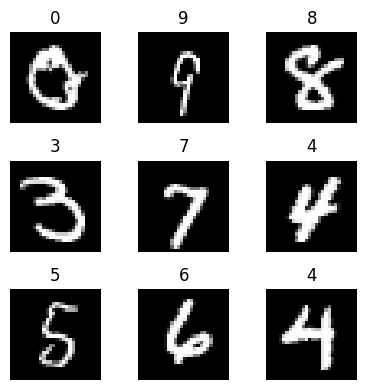

In [3]:
import matplotlib.pyplot as plt

images, labels = next(iter(train_loader))
plt.figure(figsize=(4,4))
for i in range(9):
    plt.subplot(3,3,i+1)
    plt.imshow(images[i,0], cmap="gray")
    plt.title(int(labels[i]))
    plt.axis("off")
plt.tight_layout()
plt.show()

In [4]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLP(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 100)  # 784 → 100
        self.fc2 = nn.Linear(100, 10)     # 100 → 10

    def forward(self, x):
        x = x.view(x.size(0), -1)         # flatten (N,1,28,28) → (N,784)
        x = F.relu(self.fc1(x))           # hidden activation
        x = F.log_softmax(self.fc2(x), dim=1)  # output activation
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = MLP().to(device)
model

MLP(
  (fc1): Linear(in_features=784, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=10, bias=True)
)

In [5]:
criterion = nn.NLLLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.01, momentum=0.5)

In [6]:
import time
EPOCHS = 50
train_losses = []

t0 = time.time()
for ep in range(1, EPOCHS+1):
    model.train()
    running = 0.0
    for xb, yb in train_loader:
        xb, yb = xb.to(device, non_blocking=True), yb.to(device, non_blocking=True)
        optimizer.zero_grad()
        logprobs = model(xb)
        loss = criterion(logprobs, yb)
        loss.backward()
        optimizer.step()
        running += loss.item() * xb.size(0)

    avg = running / len(train_loader.dataset)
    train_losses.append(avg)
    print(f"Epoch {ep:02d}/{EPOCHS} - train loss: {avg:.4f}")

t_train = time.time() - t0
print(f"Total training time on {device}: {t_train:.2f}s")

Epoch 01/50 - train loss: 0.4471
Epoch 02/50 - train loss: 0.2385
Epoch 03/50 - train loss: 0.1869
Epoch 04/50 - train loss: 0.1552
Epoch 05/50 - train loss: 0.1330
Epoch 06/50 - train loss: 0.1168
Epoch 07/50 - train loss: 0.1045
Epoch 08/50 - train loss: 0.0943
Epoch 09/50 - train loss: 0.0862
Epoch 10/50 - train loss: 0.0789
Epoch 11/50 - train loss: 0.0728
Epoch 12/50 - train loss: 0.0678
Epoch 13/50 - train loss: 0.0630
Epoch 14/50 - train loss: 0.0589
Epoch 15/50 - train loss: 0.0553
Epoch 16/50 - train loss: 0.0520
Epoch 17/50 - train loss: 0.0487
Epoch 18/50 - train loss: 0.0460
Epoch 19/50 - train loss: 0.0436
Epoch 20/50 - train loss: 0.0413
Epoch 21/50 - train loss: 0.0389
Epoch 22/50 - train loss: 0.0367
Epoch 23/50 - train loss: 0.0349
Epoch 24/50 - train loss: 0.0332
Epoch 25/50 - train loss: 0.0314
Epoch 26/50 - train loss: 0.0299
Epoch 27/50 - train loss: 0.0283
Epoch 28/50 - train loss: 0.0272
Epoch 29/50 - train loss: 0.0257
Epoch 30/50 - train loss: 0.0247
Epoch 31/5

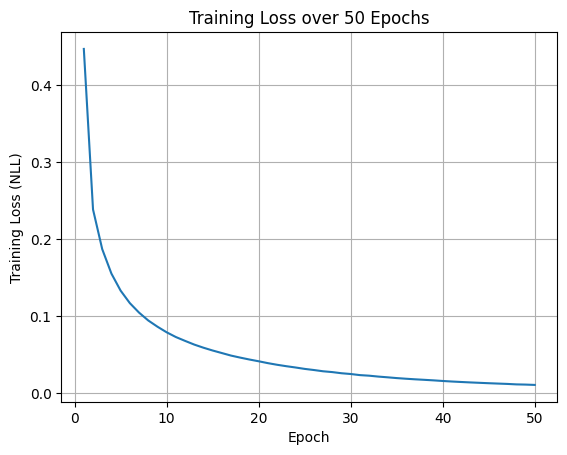

In [7]:
plt.figure()
plt.plot(range(1, EPOCHS+1), train_losses)
plt.xlabel("Epoch")
plt.ylabel("Training Loss (NLL)")
plt.title("Training Loss over 50 Epochs")
plt.grid(True)
plt.show()

In [8]:
model.eval()
test_loss, correct, total = 0.0, 0, 0

with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        logprobs = model(xb)
        test_loss += criterion(logprobs, yb).item() * xb.size(0)
        pred = logprobs.argmax(dim=1)
        correct += (pred == yb).sum().item()
        total += yb.size(0)

test_loss /= total
acc = correct / total * 100
print(f"Test Loss: {test_loss:.4f} | Test Accuracy: {acc:.2f}%")

Test Loss: 0.0700 | Test Accuracy: 98.00%


In [9]:
def time_training(device_str="cpu", epochs=5):
    dv = torch.device(device_str)
    net = MLP().to(dv)
    opt = torch.optim.SGD(net.parameters(), lr=0.01, momentum=0.5)
    crit = nn.NLLLoss()
    t0 = time.time()
    net.train()
    for _ in range(epochs):
        for xb, yb in train_loader:
            xb, yb = xb.to(dv, non_blocking=True), yb.to(dv, non_blocking=True)
            opt.zero_grad()
            loss = crit(net(xb), yb)
            loss.backward()
            opt.step()
    return time.time() - t0

cpu_time = time_training("cpu", epochs=5)
print(f"CPU time (5 epochs): {cpu_time:.2f}s")

if torch.cuda.is_available():
    gpu_time = time_training("cuda", epochs=5)
    print(f"GPU time (5 epochs): {gpu_time:.2f}s")
else:
    print("CUDA not available.")

CPU time (5 epochs): 61.75s
GPU time (5 epochs): 59.20s
